# CALF interactive testing

In [1]:
import os
from pathlib import Path


import datacube
import fiona
import geopandas
import numpy as np
import rasterio
import rasterio.features
import xarray as xr
from datacube.utils import geometry as dc_geometry

from calf import calf

## Create datacube client

And also load the auxiliary files

In [2]:
dc = datacube.Datacube(
    app="test-calf",
    env="sandbox",
    config=os.getenv("DATACUBE_CONFIG_PATH")
)

roi_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg"), layer="region-of-interest")
crop_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg", layer="crop-mask"))

/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


## Intersect region of interest and crop masks

In [3]:
intersected_df = geopandas.overlay(
    roi_df, 
    crop_df.to_crs(epsg=roi_df.crs.to_epsg()),  # reprojecting on-the-fly 
    how="intersection", 
    keep_geom_type=True
)
intersected_df

,name_1,name_2,geometry
0,municipality1,parcel1,"POLYGON ((620099.135 -2976646.642, 620097.791 ..."
1,municipality1,parcel2,"POLYGON ((620075.637 -2976449.686, 620095.723 ..."
2,municipality1,parcel3,"POLYGON ((620056.388 -2976784.130, 620009.778 ..."
3,municipality1,parcel5,"POLYGON ((620406.520 -2976741.101, 620404.416 ..."
4,municipality1,parcel6,"POLYGON ((621335.580 -2976552.240, 621746.570 ..."
5,municipality2,parcel4,"POLYGON ((619561.553 -2976624.017, 619414.410 ..."


## Process first intersected feature

For didatic purposes we are processing only the first intersected feature - the real CALF processor must perform these calulcations for all features

### Load data from the datacube

In [4]:
intersected_feature_series = intersected_df.iloc[0]
base_query = {
    "time": ("2015-01-01", "2021-12-31"),
    "measurements": ["red", "nir", "spclass"],
    "output_crs": "EPSG:32635",
    "resolution": (-10, 10),
    "resampling": "cubic",
    "geopolygon": dc_geometry.Geometry(
        intersected_feature_series.geometry.__geo_interface__,
        dc_geometry.CRS(f"EPSG:{intersected_df.crs.to_epsg()}")
    ),
    "product": "test_spot7_gauteng_old_eo3",
}

ds = dc.load(**base_query)
ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 28, y: 37)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 ... 6.201e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) int16 954 880 981 1026 916 ... 988 984 984 983
    nir          (time, y, x) int16 2027 2079 2237 2394 ... 1413 1214 1166 1138
    spclass      (time, y, x) uint8 51 66 62 67 71 57 67 ... 51 44 19 20 20 20
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

### Apply quality flags to mask out bad pixels

In [5]:
valid_ds = calf.apply_validity_mask(ds, "spclass")
valid_ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 28, y: 37)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 ... 6.201e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float64 954.0 880.0 981.0 ... 984.0 984.0 983.0
    nir          (time, y, x) float64 2.027e+03 2.079e+03 ... 1.138e+03
    spclass      (time, y, x) float64 51.0 66.0 62.0 67.0 ... 20.0 20.0 20.0
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

### Rasterize the crop mask, in preparation to have it be applied

In [6]:
crop_mask = calf.rasterize_feature(valid_ds, intersected_feature_series)

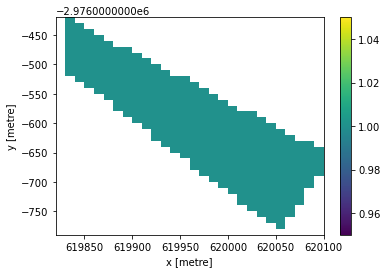

In [22]:
crop_mask.plot()

In [23]:
crop_mask

<xarray.DataArray (y: 37, x: 28)>
array([[nan,  1., nan, ..., nan, nan, nan],
       [nan,  1.,  1., ..., nan, nan, nan],
       [nan,  1.,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
  * x        (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.201e+05 6.201e+05

### Apply the crop mask to the valid ds

In [27]:
crop_ds = valid_ds * crop_mask

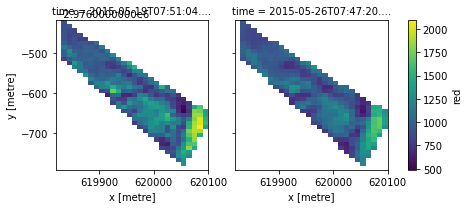

In [30]:
crop_ds.red.plot(col="time")

### Calculate individual and seasonal (i.e. aggregated) NDVI

In [31]:
ndvi_ds = (crop_ds.nir - crop_ds.red) / (crop_ds.nir + crop_ds.red)

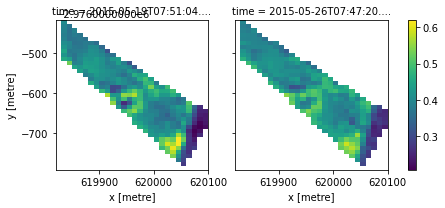

In [32]:
ndvi_ds.plot(col="time")

In [36]:
aggregated_ndvi_ds = ndvi_ds.max(dim="time")

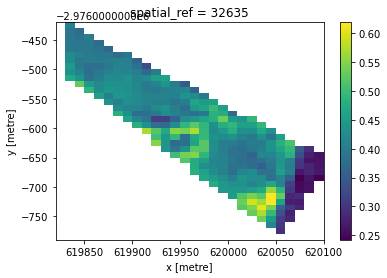

In [34]:
aggregated_ndvi_ds.plot()

In [37]:
aggregated_vegetation_ndvi = aggregated_ndvi_ds.where(aggregated_ndvi_ds > 0.2)

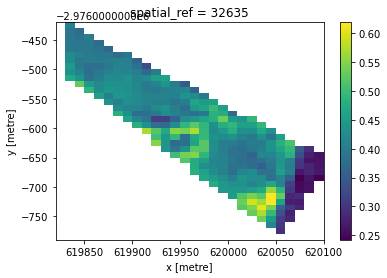

In [38]:
aggregated_vegetation_ndvi.plot()

In [39]:
mean = aggregated_vegetation_ndvi.mean()
std_dev = aggregated_vegetation_ndvi.std()
mean, std_dev

(<xarray.DataArray ()>
 array(0.41795646)
 Coordinates:
     spatial_ref  int32 32635,
 <xarray.DataArray ()>
 array(0.06767856)
 Coordinates:
     spatial_ref  int32 32635)

### Compute CALF

In [40]:
calf_ds = (aggregated_vegetation_ndvi - mean) / std_dev

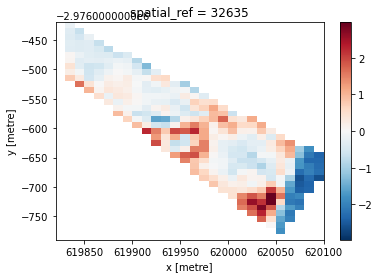

In [41]:
calf_ds.plot()

In [61]:
reclassified_calf_ds = xr.where(calf_ds <= 1, 1, 0) * crop_mask

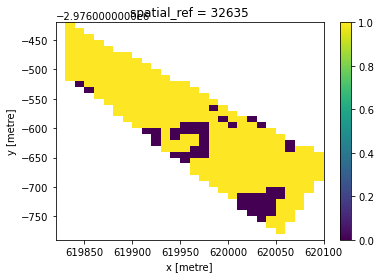

In [62]:
reclassified_calf_ds.plot()

In [66]:
counts, frequencies = np.unique(reclassified_calf_ds, return_counts=True)
frequencies

array([ 49, 298,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [78]:
frequencies[counts == 1]

array([298])

In [80]:
(~np.isnan(reclassified_calf_ds)).sum()

<xarray.DataArray ()>
array(347)
Coordinates:
    spatial_ref  int32 32635

## Using the calf package

In [5]:
result = calf._compute_calf(dc, base_query, intersected_feature_series, "spclass", 32635, 0.2)

In [7]:
result.num_fallow_pixels, result.num_planted_pixels, result.total_pixels

(array([49]),
 array([298]),
 <xarray.DataArray ()>
 array(347)
 Coordinates:
     spatial_ref  int32 32635)

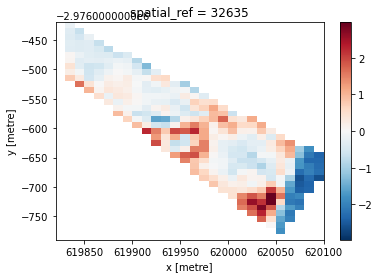

In [8]:
result.numeric_calf.plot()

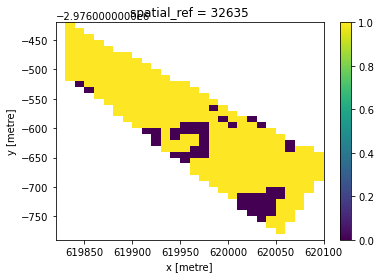

In [9]:
result.reclassified_calf.plot()